# Coursework 1
In this assignment, you will implement a decision tree algorithm and use it to determine one of the indoor locations based on WIFI signal strengths collected from a mobile phone.

## Step 1: Loading data
You can load the datasets from the files `wifi_db/clean_dataset.txt` and `wifi_db/noise_dataset.txt`. They contain a 2000x8 array.

This array represents a dataset of 2000 samples. Each sample is composed of 7 wifi signal strengths while the last column indicates the room number in which the user is standing (i.e. the label of the sample). **All the features in the dataset are continuous _except_ the room number.**

In [3]:
# Import required modules
import numpy as np
from numpy.random import default_rng

In [4]:
# Load in the datasets
clean_dataset = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_dataset = np.loadtxt('wifi_db/noisy_dataset.txt')

[[-64. -56. -61. ... -82. -81.   1.]
 [-68. -57. -61. ... -85. -85.   1.]
 [-63. -60. -60. ... -85. -84.   1.]
 ...
 [-62. -59. -46. ... -87. -88.   4.]
 [-62. -58. -52. ... -90. -85.   4.]
 [-59. -50. -45. ... -88. -87.   4.]]
[[-59. -53. -51. ... -79. -87.   4.]
 [-66. -53. -59. ... -81. -79.   1.]
 [-41. -57. -63. ... -66. -65.   2.]
 ...
 [-57. -54. -56. ... -79. -82.   1.]
 [-56. -52. -50. ... -85. -88.   3.]
 [-46. -54. -47. ... -80. -73.   3.]]


## Step 2: Creating Decision Trees
To create the decision tree, you will write a recursive function called `decision_tree_learning()`, that takes as arguments a matrix containing the dataset and a depth variable (which is used to compute the maximal depth of the tree, for plotting purposes for instance). The label of the training dataset is assumed to be the last column of the matrix.

See the psuedo-code for the algorithm below.
```
1:  procedure DECISION_TREE_LEARNING(training_dataset, depth)
2:    if all samples have the same label then
3:      return (a leaf node with this value, depth)
4:    else
5:      split ← FIND_SPLIT(training dataset)
6:      node ← a new decision tree with root as split value
7:      l_branch, l_depth ← DECISION_TREE_LEARNING(l_dataset, depth+1)
8:      r_branch, r_depth ← DECISION_TREE_LEARNING(r_dataset, depth+1)
9:      return (node, max(l_depth, r_depth))
10:   end if
11: end procedure
```

The function `FIND_SPLIT` chooses the attribute and the value that results in the highest information gain.

An efficient method for finding good split points is to sort the values of the attribute, and then consider only split points that are **between two examples in sorted order**, while keeping track of the running totals of examples of each class for each side of the split point.

To evaluate the information gain, suppose that the training dataset S_all has K different labels. We can define two subsets (S_left and S_right) of the dataset depending on the splitting rule and for each dataset and subset, we can compute the distribution (or probability) of each label. For instance, {p1, p2, ..., pk} where pk is the number of samples with the label k divided by the total number of samples from the initial dataset.

In [5]:
"""
Class used to represent decision nodes in a decision tree.

Members:
- value     : the value on which to split
- attribute : the attribute on which to split
- left      : the left sub-tree
- right     : the right sub-tree

Methods:
- is_leaf        : returns a boolean indicating whether or not this is a leaf node
- is_left_child  : returns a boolean indicating if this node is the left child of its parent
- is_right_child : returns a boolean indicating if this node is the right child of its parent
- depth          : returns a the depth of the tree with this node as its root
"""
class Node:
    def __init__(self, parent = None, value = None, attribute = None, label = None):
        self.value = value
        self.attribute = attribute
        self.left = None
        self.right = None
        self.parent = parent
        self.label = label
    
    def is_leaf(self):
        return self.left is None and self.right is None

    def is_left_child(self):
        if self.parent:
            return self.parent.left == self
        return False

    def is_right_child(self):
        if self.parent:
            return self.parent.right == self
        return False

    def depth(self):
        if (self.is_leaf()):
            return 0
        else:
            return 1 + max([self.left.depth(), self.right.depth()])

    def __str__(self) -> str:
        if self.is_leaf():
            return self.label
        else:
            return f"Node({self.left.__str__()}, {self.right.__str__()})"

In [6]:
"""
Chooses the attribute and the value that results in the highest information gain

Arguments:
- training_dataset (last column is the label)

Returns:
- tuple : Returns a tuple of (split_attribute, split_value, left_dataset, right_dataset)
          - split_attribute: The column index of the value that was split on
          - split_value: The value used to split the dataset into left and right
          - left_dataset: All elements have a `split_attribute` value < `split_value`
          - right_dataset: All elements have a `split_attribute` value >= `split_value`
"""
def find_split(training_dataset):
    best_split = (0, None)

    for attribute in range(training_dataset.shape[1] - 1):
        # Sort the rows by the current attribute's values
        sorted_attribute_indices = np.argsort(training_dataset, axis=0)[:, attribute]
        sorted_by_attribute = training_dataset[sorted_attribute_indices, :]
        # Get the index of each point where the value changes
        _, split_points = np.unique(sorted_by_attribute[:, attribute], return_index=True)
        for split_point in split_points:
            # Find the information gained from splitting at this point
            left = sorted_by_attribute[:split_point, :]
            right = sorted_by_attribute[split_point:, :]
            info_gain = information_gain(training_dataset, left, right)
            split_value = sorted_by_attribute[split_point, attribute]
            # Replace best_split if more information is gained by splitting here
            best_split = max(best_split, (info_gain, (attribute, split_value, left, right)), key=lambda x: x[0])

    return best_split[1]

# Returns the information gain when the dataset `data` is split into two distinct subsets `left` and `right`
def information_gain(data, left, right):
    return entropy(data) - remainder(left, right)

# Returns the information entropy of `dataset`
def entropy(dataset):
    _, counts = np.unique(dataset[:, -1], return_counts=True)
    probabilities = counts / counts.sum()
    return -(probabilities * np.log2(probabilities)).sum()

# Returns the (weighted) average entropy of the two subsets `left` and `right`
def remainder(left, right):
    proportion_left = len(left) / (len(left) + len(right))
    return proportion_left * entropy(left) + (1 - proportion_left) * entropy(right)

In [7]:
"""
Constructs a decision tree by learning from training_dataset.

Arguments:
- training_dataset (last column is the label)
- depth

Returns:
- A decision tree in the form of a root Node and subsequent left and right nodes
"""
def decision_tree_learning(training_dataset, depth, parent=None):
    unique_labels = np.unique(training_dataset[:,-1])
    # If all samples have the same label return a leaf node with this label
    if (len(unique_labels) == 1):
        node = Node(parent=parent, label=unique_labels[0])
        return (node, depth)
    else:
        # Find the optimum split attribute and value and the corresponding split subsets
        split_attribute, split_value, left_dataset, right_dataset = find_split(training_dataset)
        # Create a new decision tree with this split value and attribute
        node = Node(parent, split_value, split_attribute)
        # Construct the rest of the decision tree
        left_branch, left_depth = decision_tree_learning(left_dataset, depth + 1, node)
        right_branch, right_depth = decision_tree_learning(right_dataset, depth + 1, node)
        # Assign these branches to the root node
        node.left = left_branch
        node.right = right_branch
        
        return (node, max(left_depth, right_depth))

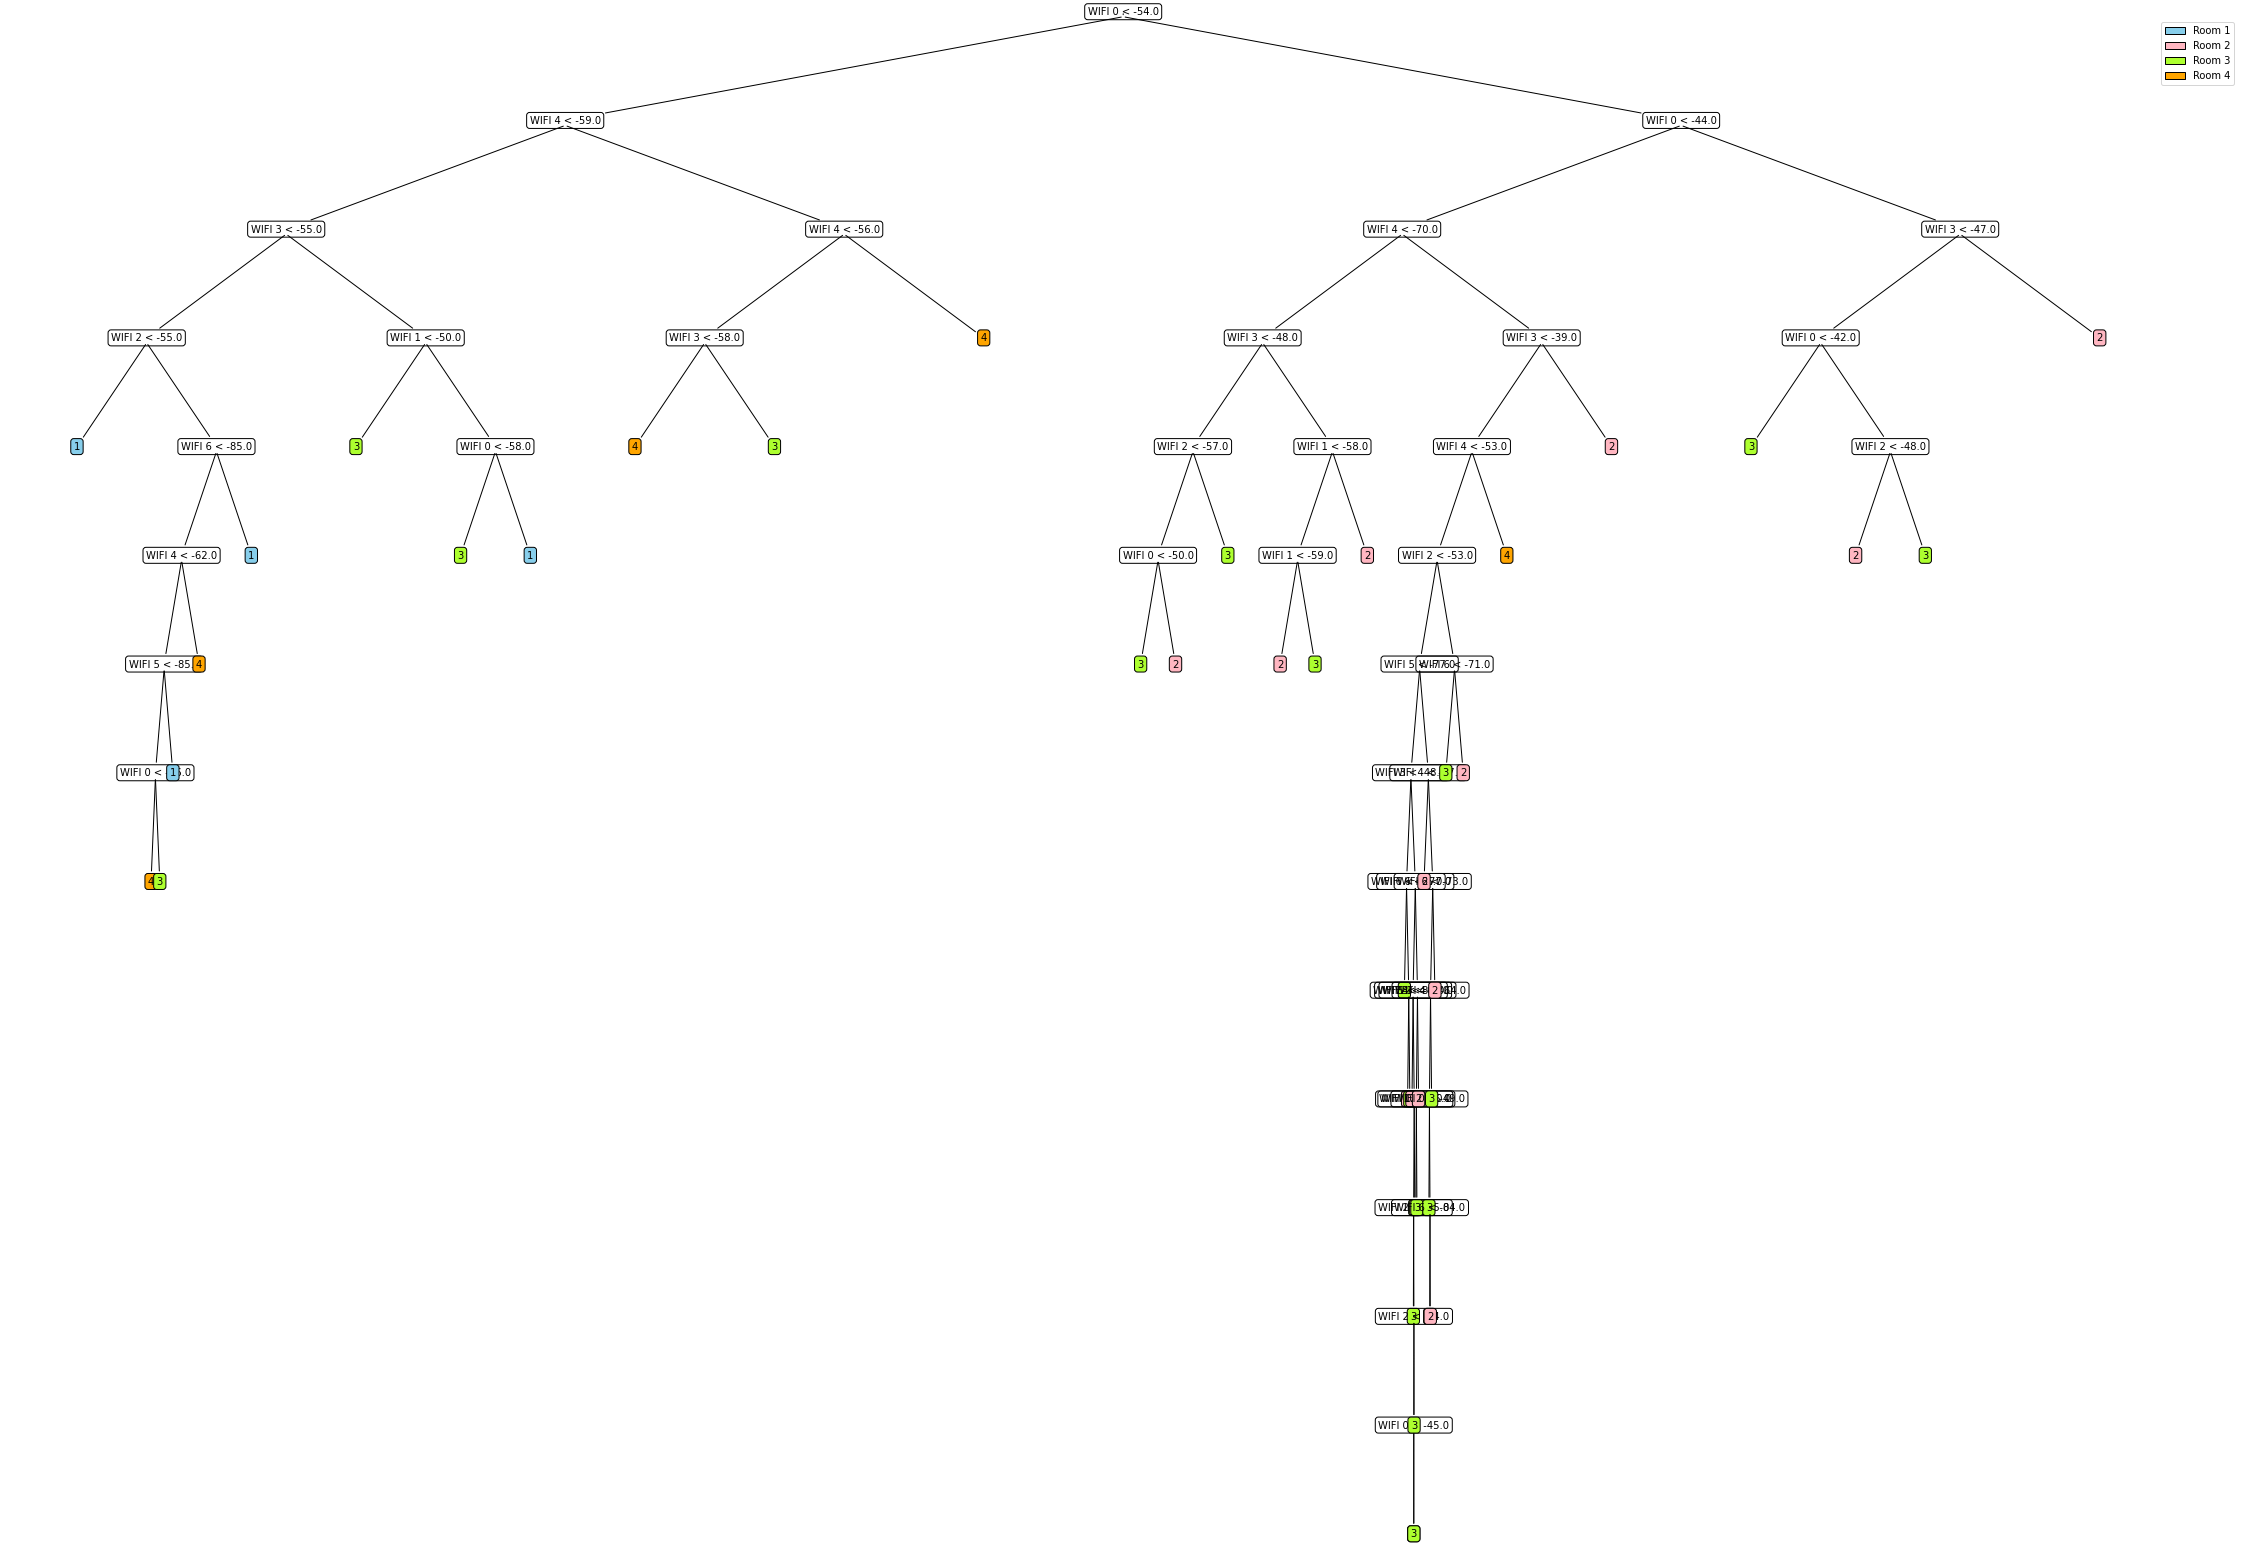

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

root_node, depth = decision_tree_learning(clean_dataset, 0)

def visualise_tree(tree):
    y_gap = 0.1
    def visualise_children(node, parent_text, parent_xy, left_x, right_x, y, depth=0):
        # if depth == 2:
        #     return
        
        # Calculate position
        mid = left_x + (right_x - left_x) * 0.5
        y -= y_gap
        
        curr_text = plot_node(node, parent_text, parent_xy, (mid, y))

        # Plot child text box
        # Them recursively plot children of children
        if node.left:
            visualise_children(node.left, curr_text, (mid, y), left_x, mid, y, depth+1)

        if node.right:
            visualise_children(node.right, curr_text, (mid, y), mid, right_x, y, depth+1)

    def plot_node(node, parent_text, xy, xytext):
        # Formatting and adjustments
        text = int(node.label) if node.is_leaf() else f"WIFI {node.attribute} < {node.value}"
        facecolor = f"{roomColors[int(node.label)]}" if node.is_leaf() else "none"

        # Plot text box
        return ax.annotate(text, xy=xy, xycoords="axes fraction",
                                xytext=xytext, textcoords="axes fraction",
                                va="bottom", ha="center",
                                bbox=dict(facecolor=facecolor, alpha=1, boxstyle="round"),
                                arrowprops=dict(arrowstyle="-"))

    def generate_legend():
        for room, color in roomColors.items():
            handles.append(mpatches.Patch(facecolor=color, edgecolor="black", label=f"Room {room}"))

    width, height = 40, 20 # feel free to increase width to spread out the tree
    roomColors = {1 : 'skyblue', 2 : 'lightpink', 3 : 'greenyellow', 4 : 'orange'}
    handles = []
    generate_legend()

    _, ax = plt.subplots(figsize=(width, height))
    ax.set_axis_off()

    visualise_children(tree, "data", (0.5, 1), 0, 1, 1 + y_gap)    
    
    plt.legend(handles=handles)
    plt.show()

print("Tree visualisation on a tree trained on the entire clean dataset:")
visualise_tree(root_node)

## Step 3: Evaluation
Evaluate your decision tree using a 10-fold cross validation on both the clean and noisy datasets. You should expect that slightly different trees will be created with each fold, since the training data that you use each time will be slightly different. Use your resulting decision trees to classify your data in your test sets.

Implement an evaluation function that takes a trained tree and a test dataset: `evaluate(test_db, trained_tree)` and that returns the accuracy of the tree.

In [9]:
"""
Decides a label for this set of features using tree

Arguments:
- features : a single example of training data
- tree     : decision tree
"""
def decide_label(features, tree):
    if (tree.is_leaf()):
        return tree.label
    
    if (features[tree.attribute] < tree.value):
        return decide_label(features, tree.left)
    else:
        return decide_label(features, tree.right)

def predict(test_db, trained_tree):
    predictions = np.zeros(len(test_db))
    for i, row in enumerate(test_db):
        predictions[i] = decide_label(row[:-1], trained_tree)
    return predictions


"""
Evaluates the performance of trained_tree on test_db

Arguments:
- test_db      : data used for testing (last column is label)
- trained_tree : trained decision tree

Returns:
- accuracy (float)
"""
def evaluate(test_db, trained_tree):
    predictions = predict(test_db, trained_tree)
    return np.sum(test_db[:, -1] == predictions) / len(test_db)

In [10]:
"""
Creates `n_folds` splits of training and test indices for a dataset containing `n_instances` rows
"""
def train_test_k_fold(n_instances, n_folds=10):
    shuffled_indices = default_rng().permutation(n_instances)
    split_indices = np.array_split(shuffled_indices, n_folds)
    folds = []

    for k in range(n_folds):
        test_indices = split_indices[k] 
        train_indices = np.concatenate(split_indices[:k] + split_indices[k+1:])
        folds.append([train_indices, test_indices])
    
    return folds

In [11]:
"""
Perform k_fold cross-validation and return the predictions and labels
"""
def cross_validation(dataset):
    predictions = []
    labels = []
    for _, (train_indices, test_indices) in enumerate(train_test_k_fold(len(dataset), 10)):
        train_set = dataset[train_indices]
        test_set = dataset[test_indices]
        tree, _ = decision_tree_learning(train_set, 0)

        predictions.append(predict(test_set, tree))
        labels.append(test_set[:, -1])

    return predictions, labels


In [12]:
"""
Compute the confusion matrix.
    
Argumentss:
- y_gold (np.ndarray): the correct ground truth/gold standard labels
- y_prediction (np.ndarray): the predicted labels
- class_labels (np.ndarray): a list of unique class labels. 
                        Defaults to the union of y_gold and y_prediction.

Returns:
- np.array : shape (C, C), where C is the number of classes. 
            Rows are ground truth per class, columns are predictions
"""
def confusion_matrix(y_gold, y_prediction, class_labels):
  
    confusion = np.zeros((len(class_labels), len(class_labels)))

    # for each correct class (row), 
    # compute how many instances are predicted for each class (columns)
    for i, row_label in enumerate(class_labels):
      ground_indices = y_gold == row_label
      label_predictions = y_prediction[ground_indices]
      labels, prediction_counts = np.unique(label_predictions, return_counts=True)
      
      label_dict = dict(zip(labels, prediction_counts))

      for j, column_label in enumerate(class_labels):
        confusion[i, j] = label_dict.get(column_label, 0)


    return confusion


def avg_confusion_matrix(predictions, labels, class_labels=None):
    if not class_labels:
        class_labels = np.unique(np.concatenate((np.vstack(predictions), np.vstack(labels)))) 
    totals = np.zeros((len(class_labels), len(class_labels)))
    for i in range(len(predictions)):
      totals += confusion_matrix(labels[i], predictions[i], class_labels)

    return totals / len(predictions)


In [13]:
"""
Compute the accuracy given the confusion matrix

Args:
- confusion (np.ndarray): shape (C, C), where C is the number of classes. 
            Rows are ground truth per class, columns are predictions

Returns:
- float : the accuracy
"""    
def accuracy_from_confusion(confusion):
    if np.sum(confusion) > 0:
        return np.sum(np.diag(confusion)) / np.sum(confusion)
    else:
        return 0.

In [14]:
"""
Compute the precision score per class given the confusion matrix
    
Args:
- confusion (np.ndarray): shape (C, C), where C is the number of classes. 
            Rows are ground truth per class, columns are predictions

Returns:
- p is a np.ndarray of shape (C,), where each element is the 
    precision for class c
"""
def precision(confusion):

    # Compute the precision per class
    p = np.zeros(len(confusion))

    for i in range(len(confusion)):
        if np.sum(confusion[:, i]) > 0:
            p[i] = confusion[i, i] / np.sum(confusion[:,i])
    
    return p

In [15]:
"""
Compute the recall score per class given the confusion matrix
    
Args:
- confusion (np.ndarray): shape (C, C), where C is the number of classes. 
            Rows are ground truth per class, columns are predictions

Returns:
- r is a np.ndarray of shape (C,), where each element is the 
    recall for class c
"""
def recall(confusion):
    # Compute the recall per class
    r = np.zeros(len(confusion))

    for i in range(len(confusion)):
        if np.sum(confusion[i, :]) > 0:
            r[i] = confusion[i, i] / np.sum(confusion[i])
    
    return r

In [16]:
"""
Compute the f1 score per class given the confusion matrix
    
Args:
- confusion (np.ndarray): shape (C, C), where C is the number of classes. 
            Rows are ground truth per class, columns are predictions

Returns:
- f is a np.ndarray of shape (C,), where each element is the 
    f1 score for class c
"""
def f1(confusion):
    recalls, precisions = recall(confusion), precision(confusion)

    f = np.zeros(len(confusion))
    for i, (r, p) in enumerate(zip(recalls, precisions)):
        f[i] = 2 * r * p / (r + p)

    return f

In [17]:
print("--------------------------------------")
print("NON-PRUNED TREE CROSS VALIDATION EVALUATION")
print("--------------------------------------")
predictions, labels = cross_validation(noisy_dataset)
confusion = avg_confusion_matrix(predictions, labels)
print("--- NOISY DATASET ---")
print("*** Confusion matrix ***")
print(confusion)
print("************")
print(f"Accuracy of noisy dataset: {accuracy_from_confusion(confusion)}")
print(f"Recall per class of noisy dataset: {recall(confusion)}")
print(f"Precision per class of noisy dataset: {precision(confusion)}")
print(f"F1 per class of noisy dataset: {f1(confusion)}")
print("--------------------")
print("")
predictions, labels = cross_validation(clean_dataset)
confusion = avg_confusion_matrix(predictions, labels)
print("--- CLEAN DATASET ---")
print("*** Confusion matrix ***")
print(confusion)
print("************")
print(f"Accuracy of clean dataset: {accuracy_from_confusion(confusion)}")
print(f"Recall per class of clean dataset: {recall(confusion)}")
print(f"Precision per class of clean dataset: {precision(confusion)}")
print(f"F1 per class of clean dataset: {f1(confusion)}")
print("---------------------")
print("--------------------------------------")

--------------------------------------
NON-PRUNED TREE CROSS VALIDATION EVALUATION
--------------------------------------
--- NOISY DATASET ---
*** Confusion matrix ***
[[38.6  3.8  3.5  3.1]
 [ 2.8 39.8  4.4  2.7]
 [ 3.3  3.2 41.1  3.9]
 [ 4.2  2.8  4.1 38.7]]
************
Accuracy of noisy dataset: 0.7909999999999999
Recall per class of noisy dataset: [0.7877551  0.80080483 0.79805825 0.77710843]
Precision per class of noisy dataset: [0.78936605 0.80241935 0.7740113  0.79958678]
F1 per class of noisy dataset: [0.78855975 0.80161128 0.78585086 0.78818737]
--------------------

--- CLEAN DATASET ---
*** Confusion matrix ***
[[49.6  0.   0.2  0.2]
 [ 0.  47.6  2.4  0. ]
 [ 0.4  1.9 47.5  0.2]
 [ 0.4  0.   0.2 49.4]]
************
Accuracy of clean dataset: 0.9704999999999999
Recall per class of clean dataset: [0.992 0.952 0.95  0.988]
Precision per class of clean dataset: [0.98412698 0.96161616 0.944334   0.99196787]
F1 per class of clean dataset: [0.98804781 0.95678392 0.94715852 0.9899

# Step 4 - Pruning
In order to reduce the performance difference of our decision tree between the clean and noisy dataset, you will
implement a pruning function based on reducing the validation error. This approach works as follow: for each
node directly connected to two leaves, evaluate the benefits on the validation error of substituting this node
with a single leaf (defined according to the training set). If a single leaf reduces the validation error, then the
node in pruned and replaced by a single leaf. The tree needs to be parsed several times until there is no more
node connected to two leaves (HINT: when you prune a node, the parent node might now verify this condition).

In [18]:
# Recurse through the tree finding all nodes having two leaves as children. Return the list of these nodes
def get_all_double_leafed_nodes(tree):
  if tree.left.is_leaf() and tree.right.is_leaf():
    return [tree]
  double_leafed_nodes = []
  if not tree.left.is_leaf():
    double_leafed_nodes += get_all_double_leafed_nodes(tree.left)
  if not tree.right.is_leaf():
    double_leafed_nodes += get_all_double_leafed_nodes(tree.right)
  return double_leafed_nodes

# Function to either replace a non-leaf node with a leaf node, or vice versa.
def replace(to_replace, to_add):
  to_add.parent = to_replace.parent
  if to_replace.is_left_child():
    to_replace.parent.left = to_add
  elif to_replace.is_right_child():
    to_replace.parent.right = to_add
  # Did I replace root node
  return to_add.parent == None

"""
Prune the provided tree, repeatedly substituting nodes directly connected to two leaves with a single leaf,
if it is found that doing so will improve the accuracy of the decision tree on the provided validation set.
    
Args:
- tree (Node): the trained tree that is to be pruned
- validation_dataset (np.ndarray): the validation set

Returns:
- num_pruned: the number of nodes that were pruned in the process
"""
def prune(tree, validation_dataset):
  num_pruned = 0
  double_leafed_nodes = get_all_double_leafed_nodes(tree)
  while double_leafed_nodes:
    current_accuracy = evaluate(validation_dataset, tree)
    to_prune = double_leafed_nodes.pop(0)
    left_leaf = Node(label=to_prune.left.label)
    right_leaf = Node(label=to_prune.right.label)

    # What would the accuracy be if we replaced the node with its left child?
    replaced_root = replace(to_prune, left_leaf)
    accuracy_left_prune = evaluate(validation_dataset, tree if not replaced_root else left_leaf)

    # What would the accuracy be if we replaced the node with its right child?
    replaced_root = replace(left_leaf, right_leaf)
    accuracy_right_prune = evaluate(validation_dataset, tree if not replaced_root else right_leaf)

    in_tree = right_leaf
    # If the accuracy was better before the prune, return the tree to its previous state
    if current_accuracy > accuracy_left_prune and current_accuracy > accuracy_right_prune:
      replace(right_leaf, to_prune)
      in_tree = to_prune
    elif accuracy_left_prune >= accuracy_right_prune:
      replace(right_leaf, left_leaf)
      in_tree = left_leaf
      num_pruned+=1
    else:
      num_pruned+=1

    # Handle the case where we just replaced the root node with one of its children - probably unecessary
    # but nice for completeness
    if not in_tree.parent:
      tree.left = None
      tree.right = None
      tree.label = in_tree.label
      # Check if this prune has made the parent node a new candidate for pruning
    elif in_tree.parent.left.is_leaf() and in_tree.parent.right.is_leaf():
      double_leafed_nodes.append(in_tree.parent)

  return num_pruned

In [19]:
"""
Perform nested_k_fold cross-validation and return the predictions, labels, average tree depth before and after pruning
"""
def nested_k_fold(dataset, n_outer_folds=10, n_inner_folds=9):
    predictions = []
    labels = []
    total_depth_before_pruning = 0
    total_depth_after_pruning = 0
    # Outer CV (10-fold)
    for rest, test_indices in train_test_k_fold(len(dataset), n_outer_folds):
        test_set = dataset[test_indices, :]

        # Inner CV (I used 9-fold)    
        for train_indices, val_indices in train_test_k_fold(len(rest), n_inner_folds): 
            # Grab a dev fold
            training_set = dataset[rest[train_indices], :]
            validation_set = dataset[rest[val_indices], :]

            # Train the tree with remainder data
            tree, depth_before = decision_tree_learning(training_set, 0)
            total_depth_before_pruning += depth_before
            
            # Prune the tree using the dev fold
            prune(tree, validation_set)
            total_depth_after_pruning += tree.depth()

            # Use pruned tree to test on *test* data
            predictions.append(predict(test_set, tree))
            labels.append(test_set[:, -1])

    avg_depth_before = total_depth_before_pruning / (n_outer_folds * n_inner_folds)
    avg_depth_after = total_depth_after_pruning / (n_outer_folds * n_inner_folds)

    return predictions, labels, avg_depth_before, avg_depth_after

In [20]:
print("--------------------------------------")
print("PRUNED TREE CROSS VALIDATION EVALUATION")
print("--------------------------------------")
predictions, labels, depth_before, depth_after = nested_k_fold(noisy_dataset)
confusion = avg_confusion_matrix(predictions, labels)
print("--- NOISY DATASET ---")
print(f"Average depth before pruning: {depth_before}")
print(f"Average depth after pruning: {depth_after}")
print("*** Confusion matrix ***")
print("************")
print(f"Accuracy of noisy dataset: {accuracy_from_confusion(confusion)}")
print(f"Recall per class of noisy dataset: {recall(confusion)}")
print(f"Precision per class of noisy dataset: {precision(confusion)}")
print(f"F1 per class of noisy dataset: {f1(confusion)}")
print("--------------------")
print("")
predictions, labels, depth_before, depth_after = nested_k_fold(clean_dataset)
confusion = avg_confusion_matrix(predictions, labels)
print("--- CLEAN DATASET ---")
print(f"Average depth before pruning: {depth_before}")
print(f"Average depth after pruning: {depth_after}")
print("*** Confusion matrix ***")
print(confusion)
print("************")
print(f"Accuracy of clean dataset: {accuracy_from_confusion(confusion)}")
print(f"Recall per class of clean dataset: {recall(confusion)}")
print(f"Precision per class of clean dataset: {precision(confusion)}")
print(f"F1 per class of clean dataset: {f1(confusion)}")
print("---------------------")
print("--------------------------------------")

--------------------------------------
PRUNED TREE CROSS VALIDATION EVALUATION
--------------------------------------
--- NOISY DATASET ---
Average depth before pruning: 18.08888888888889
Average depth after pruning: 9.61111111111111
*** Confusion matrix ***
************
Accuracy of noisy dataset: 0.8727222222222221
Recall per class of noisy dataset: [0.89297052 0.86094344 0.85199569 0.8859884 ]
Precision per class of noisy dataset: [0.86606554 0.87822121 0.86166267 0.88539576]
F1 per class of noisy dataset: [0.87931227 0.8694965  0.85680191 0.88569198]
--------------------



ValueError: too many values to unpack (expected 2)